In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 47.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 25.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 89.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 77.0 MB/s eta 0:00:00


In [40]:

import torch
import pandas as pd

# Télécharger le fichier parquet
df = pd.read_parquet("/content/drive/MyDrive/preprocesses_tweets.parquet")

In [36]:

from sklearn.feature_extraction.text import TfidfVectorizer


vectorizer = TfidfVectorizer()

text_data = df['preprocessed_tweet']


tfidf_matrix = vectorizer.fit_transform(text_data)




In [42]:
from scipy.sparse import vstack

# Concaténation de toutes les matrices TF-IDF en une seule matrice
tfidf_matrix1 = vstack(tfidf_matrix)

In [26]:
print("Le nombre de documents est : ", tfidf_matrix1.shape[0])
print("Le nombre de caractéristiques est : ", tfidf_matrix1.shape[1])


Le nombre de documents est :  14634242
Le nombre de caractéristiques est :  4063991


In [15]:
# Pour un fichier .mtx
from scipy.io import mmread
tfidf_matrix1 = mmread('/content/drive/MyDrive/tfidf_matrix.mtx')


In [27]:
from sklearn.decomposition import TruncatedSVD
from sklearn.utils import shuffle
from sklearn.ensemble import IsolationForest
# Mélanger les données
tfidf_matrix1 = shuffle(tfidf_matrix1, random_state=1)

# Prendre les 100 000 premiers documents
tfidf_matrix1_sample = tfidf_matrix1[:1000000]

# Définir le nombre de dimensions cible
n_components = 100  # Ajustez ce nombre en fonction de vos besoins

# Créer le transformateur SVD
svd = TruncatedSVD(n_components=n_components)

# Appliquer la transformation
tfidf_matrix1_reduced = svd.fit_transform(tfidf_matrix1_sample)

# utiliser `tfidf_matrix1_reduced` pour entraîner le modèle :
clf = IsolationForest(contamination=0.1, n_jobs=-1)
clf.fit(tfidf_matrix1_reduced)
preds = clf.predict(tfidf_matrix1_reduced)


In [28]:
import pandas as pd

# Conversion du tableau de prédiction en pandas Series
preds_series = pd.Series(preds)

# Ajout de la série des prédictions au dataframe
df['anomaly'] = preds_series

# Affichage des tweets anormaux
anomalies = df[df['anomaly'] == -1]['preprocessed_tweet']
#print(anomalies)


In [ ]:
anomalies.to_csv('/content/drive/MyDrive/anomalies3.csv', index=False)


In [ ]:
mmwrite('/content/drive/MyDrive/tfidf_matrix.mtx', tfidf_matrix1)

In [ ]:
from google.colab import files
files.download('tfidf_matrix.mtx')

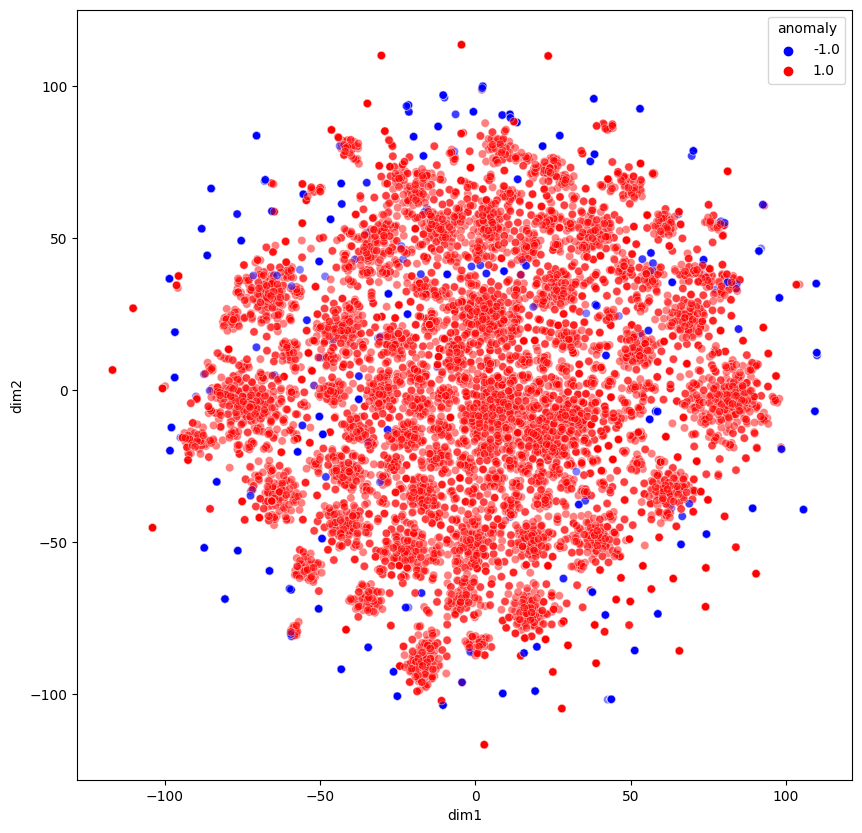

In [19]:
import numpy as np

# Si tfidf_matrix1_reduced est un tableau numpy
sample_size = 10000
indices = np.random.choice(tfidf_matrix1_reduced.shape[0], size=sample_size, replace=False)
tfidf_matrix1_reduced_sample = tfidf_matrix1_reduced[indices]
anomaly_sample = df['anomaly'].values[indices]

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# Utiliser t-SNE pour réduire à 2 dimensions
tsne = TSNE(n_components=2, random_state=0)
tfidf_matrix1_reduced_2d = tsne.fit_transform(tfidf_matrix1_reduced_sample)

# Préparer le dataframe pour le tracé
plot_df = pd.DataFrame(columns=["dim1", "dim2", "anomaly"])
plot_df["dim1"], plot_df["dim2"], plot_df["anomaly"] = tfidf_matrix1_reduced_2d[:, 0], tfidf_matrix1_reduced_2d[:, 1], anomaly_sample

# Tracer les données
plt.figure(figsize=(10, 10))
sns.scatterplot(data=plot_df, x="dim1", y="dim2", hue="anomaly", palette=["blue", "red"], alpha=0.5)
plt.show()


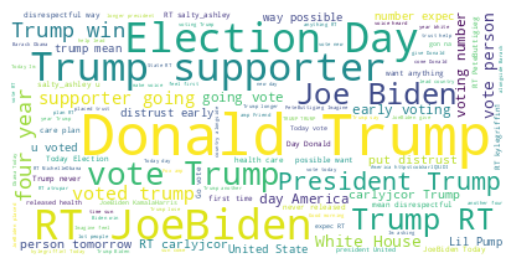

In [22]:
from wordcloud import WordCloud
# Fusionner tous les tweets anormaux en une seule chaîne de texte
anomalies_text = " ".join(tweet for tweet in anomalies)

# Créer et afficher le wordcloud
wordcloud = WordCloud(background_color='white').generate(anomalies_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


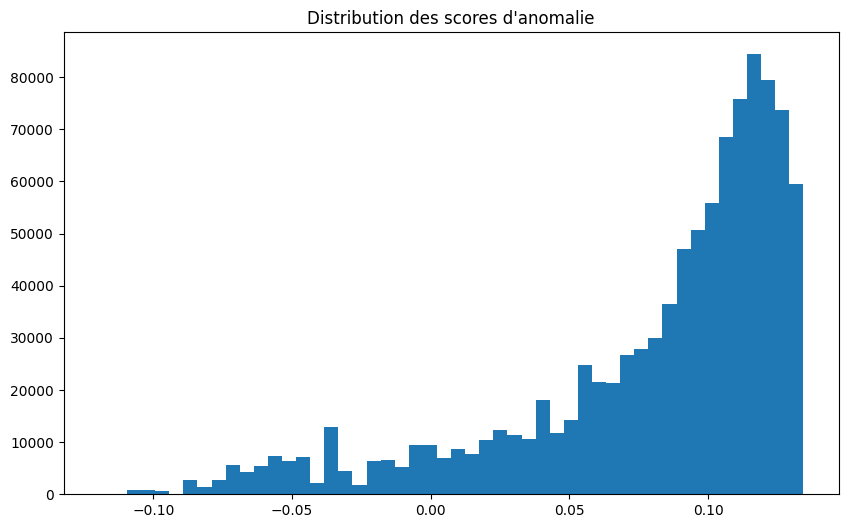

In [23]:
scores = clf.decision_function(tfidf_matrix1_reduced)
plt.figure(figsize=(10, 6))
plt.hist(scores, bins=50)
plt.title('Distribution des scores d\'anomalie')
plt.show()


In [34]:
from sklearn.ensemble import IsolationForest
# Créer l'instance du modèle
clf = IsolationForest(contamination=0.1, n_jobs=-1)

# Entraîner le modèle
clf.fit(tfidf_matrix1_reduced)

# Les scores d'anomalie
scores = clf.decision_function(tfidf_matrix1_reduced)




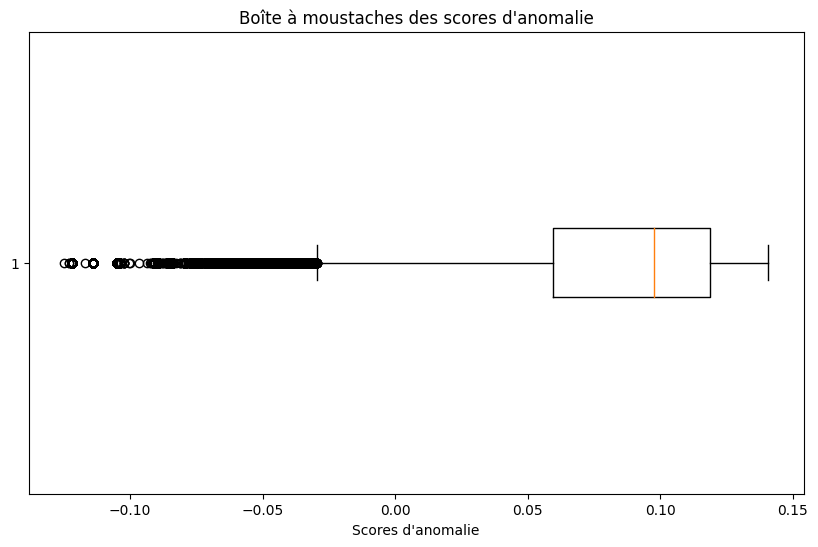

In [35]:


# Tracer une boîte à moustaches des scores
plt.figure(figsize=(10,6))
plt.boxplot(scores, vert=False)
plt.xlabel('Scores d\'anomalie')
plt.title('Boîte à moustaches des scores d\'anomalie')
plt.show()
